# PACE and Field Campaign Site Matchups

## Introduction

This tutorial demonstrates how to use Earth observation data from NASA's PACE (Plankton, Aerosol, Cloud, ocean Ecosystem) mission alongside in situ field campaign data to analyze remote sensing reflectance and biogeochemical measurements (e.g., chlorophyll a and phytoplankton carbon). This notebook was developed for the Airborne Validation Unified Experiment Land to Ocean (AVUELO) - Costa Rica boat station matchups and uses PACE's biogeochemical (BGC) and apparnt optical property (AOP) near real time data sources.

By the end of this tutorial, you will:

- Match field measurements with PACE satellite data

- Visualize geospatial and spectral data 

---

*Notebook prepared by Kelly Luis, Jet Propulsion Laboratory, California Institute of Technology, 2025.*


## 1. Setup and Dependencies

### Install Required Packages

We first ensure that all necessary Python packages are installed:

In [57]:
# Load Modules
#!pip install earthaccess seaborn owslib

### Import Libraries

In [1]:
# Load Modules
import earthaccess
import xarray as xr
from xarray.backends.api import open_datatree
import matplotlib.pyplot as plt
import cartopy
import numpy as np
import h5netcdf
from IPython.display import JSON
import geopandas as gpd
from shapely.geometry import Point, LineString
import re
import pandas as pd
import seaborn as sns
import cartopy.crs as ccrs
import pace_func
import cartopy.feature as cfeature
from owslib.wmts import WebMapTileService

## 2. Authentification

To access NASA Earthdata, you need to authenticate using earthaccess. Follow the interactive prompt to log in with your NASA Earthdata credentials.

In [3]:
# Authenticate
auth = earthaccess.Auth()
auth.login(strategy="interactive", persist=True)
print('Authenticated:', auth.authenticated)

Enter your Earthdata Login username:  m11keluis
Enter your Earthdata password:  ········


Persisting credentials to .netrc
Authenticated: True


## 3. Load In Situ Data

We work with an in situ dataset from AVUELO's Costa Rica boat stations.

In [4]:
# Load Cast Data
insitu_df = pd.read_csv('../data/cast_info.csv').dropna()
insitu_df['timestamp'] = pd.to_datetime(insitu_df['timestamp'])

### Preview the In Situ Dataset

In [61]:
insitu_df.head()

,cast_number,latitude,longitude,timestamp
0,1.0,9.751767,-84.685650,2025-02-17 13:58:00
1,2.0,9.918883,-84.760250,2025-02-17 15:10:00
2,3.0,9.952317,-84.956583,2025-02-17 16:37:00
4,4.0,9.872467,-84.885083,2025-02-17 17:39:00
5,5.0,9.708533,-84.922283,2025-02-17 18:55:00


### Visualizing Sampling Locations

We convert the dataset into a geodataframe to plot them on a map

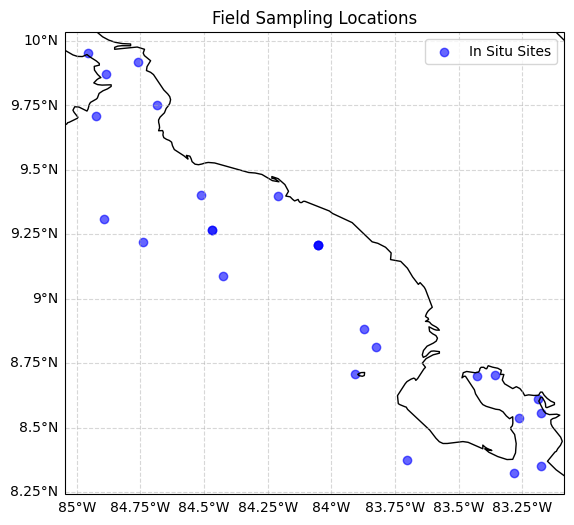

In [63]:
# Convert Sites to Geodataframe format
insitu_df['geometry'] = insitu_df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
gdf = gpd.GeoDataFrame(insitu_df, geometry='geometry', crs='EPSG:4326')

# Plot Figure
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Add high-resolution coastlines
ax.coastlines(resolution='10m')

# Add gridlines
gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)
gl.top_labels = gl.right_labels = False

# Plot sampling locations
gdf.plot(ax=ax, marker='o', color='blue', alpha=0.6, transform=ccrs.PlateCarree(), label='In Situ Sites')

plt.title('Field Sampling Locations')
plt.show()

## 4. Matching Satellite Data with Field Sites

We need to match field-measured (in situ) data with corresponding satellite-derived observations. For this example, we focus on near real time (NRT) PACE data, but this can be updated to science quality data. The process of comparing in situ and satellite data involves several key steps:

### Step 1: Define Satellite Data Search Criteria

We define the search criteria to query satellite data that corresponds temporally and spatially with our field measurements. This involves specifying:

- **Date range:** The time window around the dates of our in situ measurements.
- **Bounding box:** Geographic area covering all field sampling locations, with a small padding to ensure comprehensive coverage.

In [5]:
# Search Criteria
doi_start = "2025-02-17"
doi_end = "2025-02-22"
tspan = (doi_start, doi_end)
pad = 0.5
N=np.max(insitu_df['latitude'] + pad)
S = np.min(insitu_df['latitude'] - pad)
W = np.min(insitu_df['longitude'] - pad)
E= np.max(insitu_df['longitude'] + pad)
bbox=(W, S, E, N)

### Step 2: Search and Access PACE Satellite Imagery

We use `earthaccess` module to search and retrieve imagery from NASA's PACE satellite, specifically targeting two primary data products:

- **PACE OCI Level 2 Biogeochemical (BGC) data:** Includes parameters such as chlorophyll a, phytoplankton carbon, and other biogeochemical variables.
- **PACE OCI Level 2 Apparent Optical Properties (AOP) data:** Contains apparent optical property (AOP) PACE data, including remote sensing reflectance, apparent visible wavelength, and normalized fluorescence line height 

Data are filtered based on our defined spatial bounding box and temporal window.

In [7]:
# Search for PACE BGC Imagery
bgc_results = earthaccess.search_data(
    short_name="PACE_OCI_L2_BGC_NRT",
    temporal=tspan,
    bounding_box=bbox,
)

bgc_paths = earthaccess.open(bgc_results)

# Search for PACE AOP Imagery
aop_results = earthaccess.search_data(
    short_name="PACE_OCI_L2_AOP_NRT",
    temporal=tspan,
    bounding_box=bbox,
)

aop_paths = earthaccess.open(aop_results)

Granules found: 8
Opening 8 granules, approx size: 0.14 GB


QUEUEING TASKS | :   0%|          | 0/8 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/8 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/8 [00:00<?, ?it/s]

Granules found: 8
Opening 8 granules, approx size: 1.83 GB


QUEUEING TASKS | :   0%|          | 0/8 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/8 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/8 [00:00<?, ?it/s]

### Step 3: Match PACE BGC Satellite Pixels with Field Sites

To accurately compare satellite-derived biogeochemical parameters with our field measurements, we follow these steps:

- **Loop through each satellite imagery file** retrieved from our previous search.
- **Extract date information** from each filename to match satellite observations temporally with field data.
- **Process satellite data efficiently** by caching previously loaded datasets to avoid redundant processing.
- **Identify in situ measurements** collected on the same day as satellite observations.
- **Locate the closest satellite pixel** to each field site for parameters of interest (e.g., chlorophyll-a, Rrs, etc.).
- **Compile results** from each satellite-field matchup into a unified dataframe for further analysis.

The resulting dataframe (`XXX_df`) contains matched satellite and in situ observations, facilitating straightforward statistical comparisons and visualization.


#### BGC Dataset

In [35]:
# Initialize a cache to avoid redundant data loading
bgc_data_cache = {}

# List to collect matched dataframes for each site
site_df_list = []

# Iterate through each BGC satellite data file
for bgc_path in bgc_paths:
    print(f"Processing file: {bgc_path}")

    # Extract date information from the satellite filename
    filename = bgc_path.full_name
    date_match = re.search(r"\.(\d{8})T", filename)
    temp_bgctime = date_match.group(1) if date_match else None

    # Proceed only if a valid date is found
    if temp_bgctime:
        temp_bgctime_dt = pd.to_datetime(temp_bgctime).date()

        # Check if the dataset is already processed and cached
        if filename not in bgc_data_cache:
            # Process the satellite dataset (Level 2) and store in cache
            bgc_dataset = pace_func.process_l2(bgc_path)
            bgc_data_cache[filename] = bgc_dataset
        else:
            # Load dataset directly from cache
            bgc_dataset = bgc_data_cache[filename]

        # Select in situ measurements collected on the same day as satellite data
        matched_insitu = insitu_df[insitu_df['timestamp'].dt.date == temp_bgctime_dt]

        # Loop through matched in situ measurement locations
        for _, idata in matched_insitu.iterrows():

            # Create a dataframe entry for each matched satellite-in situ pair
            site_df = pd.DataFrame({
                "cast": [float(idata['cast_number'])],               # Cast number from field data
                "date": [temp_bgctime],                            # Observation date
                "bgc_filename": [filename],                         # Satellite file reference
                "latitude": [float(idata['latitude'])],                   # Latitude of in situ site
                "longitude": [float(idata['longitude'])],                 # Longitude of in situ site
                "chlor_a": [float(pace_func.nearest_val(                 # Closest satellite chlorophyll-a value
                    bgc_dataset, 'chlor_a', idata['latitude'], idata['longitude']
                ).values)],
                "carbon_phyto": [float(pace_func.nearest_val(            # Closest satellite phytoplankton carbon value
                    bgc_dataset, 'carbon_phyto', idata['latitude'], idata['longitude']
                ).values)]
            })

            # Append the dataframe to the list
            site_df_list.append(site_df)

# Concatenate all matched site dataframes into one comprehensive dataframe
bgc_df = pd.concat(site_df_list)


Processing file: <File-like object HTTPFileSystem, https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250217T175923.L2.OC_BGC.V3_0.NRT.nc>
Processing file: <File-like object HTTPFileSystem, https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250217T180423.L2.OC_BGC.V3_0.NRT.nc>
Processing file: <File-like object HTTPFileSystem, https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250218T183457.L2.OC_BGC.V3_0.NRT.nc>
Processing file: <File-like object HTTPFileSystem, https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250219T173209.L2.OC_BGC.V3_0.NRT.nc>
Processing file: <File-like object HTTPFileSystem, https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250219T173709.L2.OC_BGC.V3_0.NRT.nc>
Processing file: <File-like object HTTPFileSystem, https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250219T191031.L2.OC_BGC.V3_0.NRT.nc>
Processing

#### AOP Dataset

In [47]:
# Initialize a cache to store previously loaded AOP datasets
aop_data_cache = {}

# List to accumulate matched site dataframes
site_df_list = []

# Placeholder for wavelength data
wl = None

# Iterate through each AOP satellite data file
for aop_path in aop_paths:
    print(f"Processing file: {aop_path}")

    # Extract the date from the satellite filename
    filename = aop_path.full_name
    date_match = re.search(r"\.(\d{8})T", filename)
    temp_aoptime = date_match.group(1) if date_match else None

    # Only proceed if the extracted date is valid
    if temp_aoptime:
        temp_aoptime_dt = pd.to_datetime(temp_aoptime).date()

        # Check cache to avoid redundant loading of datasets
        if filename not in aop_data_cache:
            # Load and process AOP satellite data (Level 2) if not already cached
            aop_dataset = pace_func.process_l2(aop_path)
            aop_data_cache[filename] = aop_dataset

            # Pull Wavelength data only once (for the first loaded dataset)
            if wl is None:
                wl_dataset = xr.open_dataset(aop_path, group="sensor_band_parameters")
                wl = wl_dataset['wavelength_3d'].values
        else:
            # Retrieve dataset from cache if previously loaded
            aop_dataset = aop_data_cache[filename]

        # Select field measurements collected on the same day as satellite data
        matched_insitu = insitu_df[insitu_df['timestamp'].dt.date == temp_aoptime_dt]

        # Loop through each matched in situ measurement
        for _, idata in matched_insitu.iterrows():

            # Create dataframe for matched satellite-in situ pairs with AOP parameters
            site_df = pd.DataFrame({
                "cast": [float(idata['cast_number'])],             # Cast number of field measurement
                "date": [temp_aoptime],                            # Observation date
                "aop_filename": [filename],                            # Satellite filename
                "latitude": [float(idata['latitude'])],                   # Latitude of in situ site
                "longitude": [float(idata['longitude'])],                 # Longitude of in situ site
                "avw": [float(pace_func.nearest_val(               # Closest satellite AVW value
                    aop_dataset, 'avw', idata['latitude'], idata['longitude']
                ).values)],
                "Rrs": [pace_func.nearest_val(               # Closest satellite remote sensing reflectance (Rrs)
                    aop_dataset, 'Rrs', idata['latitude'], idata['longitude']
                ).values],
                "wl": [wl.astype(float)]                           # Wavelength data
            })

            # Append individual site dataframe to the list
            site_df_list.append(site_df)

# Concatenate individual dataframes into one comprehensive dataframe for AOP data
aop_df = pd.concat(site_df_list)

Processing file: <File-like object HTTPFileSystem, https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250217T175923.L2.OC_AOP.V3_0.NRT.nc>
Processing file: <File-like object HTTPFileSystem, https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250217T180423.L2.OC_AOP.V3_0.NRT.nc>
Processing file: <File-like object HTTPFileSystem, https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250218T183457.L2.OC_AOP.V3_0.NRT.nc>
Processing file: <File-like object HTTPFileSystem, https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250219T173209.L2.OC_AOP.V3_0.NRT.nc>
Processing file: <File-like object HTTPFileSystem, https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250219T173709.L2.OC_AOP.V3_0.NRT.nc>
Processing file: <File-like object HTTPFileSystem, https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250219T191031.L2.OC_AOP.V3_0.NRT.nc>
Processing

## 5. Save Matched Satellite and In Situ Dataframes

We save the finalized dataframes containing matched PACE satellite observations (BGC and AOP products) and in situ measurements. These CSV files allow for easy sharing, further analysis, and visualization without needing to rerun the previous processing steps.

In [48]:
# Save Dataframe
bgc_df.to_csv('../data/bgc_df_250224.csv')
aop_df.to_csv('../data/aop_df_250224.csv')

## 6. Visualize Rrs Spectra and Associated Biogeochemistry Values

The following step merges the biogeochemical measurements (bgc_df) with the apparent optical property data (aop_df). The datasets are matched based on common fields: 'cast', 'date', 'latitude', and 'longitude'. After merging, any incomplete entries (containing NaN) are dropped, leaving only valid, matched observations.

In [60]:
matched_df = pd.merge(bgc_df, aop_df, on=['cast', 'date', 'latitude', 'longitude'], how='inner').dropna()

# Preview Dataset
matched_df

,cast,date,bgc_filename,latitude,longitude,chlor_a,carbon_phyto,aop_filename,avw,Rrs,wl
0,1.0,20250217,https://obdaac-tea.earthdatacloud.nasa.gov/ob-...,9.751767,-84.685650,4.972672,80.578186,https://obdaac-tea.earthdatacloud.nasa.gov/ob-...,474.479858,"[0.006368, 0.0065940022, 0.006492, 0.006306, 0...","[346.0, 348.0, 351.0, 353.0, 356.0, 358.0, 361..."
2,2.0,20250217,https://obdaac-tea.earthdatacloud.nasa.gov/ob-...,9.918883,-84.760250,13.391807,126.925117,https://obdaac-tea.earthdatacloud.nasa.gov/ob-...,491.407074,"[0.003791999, 0.0037040003, 0.003842, 0.003876...","[346.0, 348.0, 351.0, 353.0, 356.0, 358.0, 361..."
6,4.0,20250217,https://obdaac-tea.earthdatacloud.nasa.gov/ob-...,9.872467,-84.885083,6.325386,207.843597,https://obdaac-tea.earthdatacloud.nasa.gov/ob-...,515.534058,"[0.0030880012, 0.0033340007, 0.0034000017, 0.0...","[346.0, 348.0, 351.0, 353.0, 356.0, 358.0, 361..."
15,3.0,20250217,https://obdaac-tea.earthdatacloud.nasa.gov/ob-...,9.952317,-84.956583,17.156197,88.786293,https://obdaac-tea.earthdatacloud.nasa.gov/ob-...,552.113586,"[0.00022000074, 0.00037400052, 0.00041599944, ...","[346.0, 348.0, 351.0, 353.0, 356.0, 358.0, 361..."
150,21.0,20250221,https://obdaac-tea.earthdatacloud.nasa.gov/ob-...,8.811250,-83.824167,0.221446,21.802689,https://obdaac-tea.earthdatacloud.nasa.gov/ob-...,465.075592,"[0.007550001, 0.0077260025, 0.00753, 0.0078199...","[346.0, 348.0, 351.0, 353.0, 356.0, 358.0, 361..."


### Plotting PACE Spectral Reflectance at Boat Stations 
The following code generates plots of spectral remote sensing reflectance across wavelengths for each individual cast. Each spectrum is represented by markers connected with lines, allowing for visualization of spectral shape variability between boat stations during the field campaign.

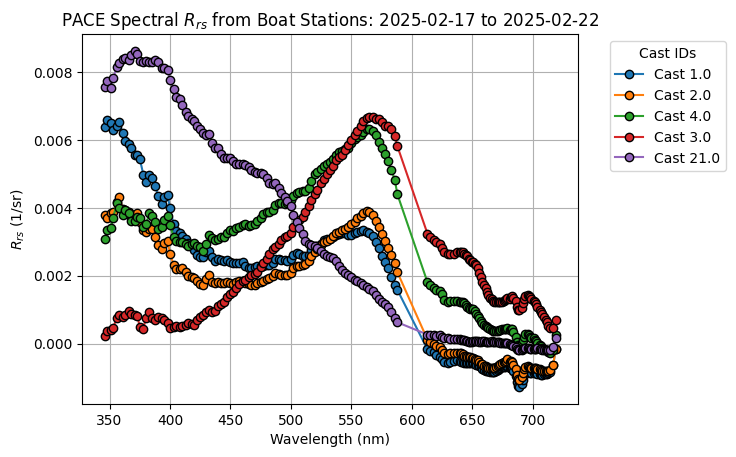

In [68]:
# Initialize figure and axes for plotting
fig, ax = plt.subplots()

# Plot each spectrum (cast) individually
for _, row in matched_df.iterrows():
    # Plot Rrs spectrum with markers and lines for each cast
    ax.plot(
        row['wl'], row['Rrs'], 
        marker='o', linestyle='-', markeredgecolor='k',
        label=f"Cast {row.get('cast', '')}"  # Label each spectrum by its cast identifier
    )

# Add legend to identify casts
plt.legend(title='Cast IDs', bbox_to_anchor=(1.05, 1), loc='upper left')

# Label the x-axis and y-axis clearly
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel(r"$R_{rs}$ (1/sr)")

# Add descriptive title including the date range of data
ax.set_title(f"PACE Spectral $R_{{rs}}$ from Boat Stations: {doi_start} to {doi_end}")

# Enable grid lines for easier interpretation
ax.grid(True)

# Display the finalized plot
plt.show()


### Summary and Next Steps

In this tutorial, we've explored how to match and visualize NASA’s PACE satellite data with in situ measurements from field campaigns, specifically from the AVUELO Costa Rica boat stations. Through this process, you've learned how to:

- Merge satellite-derived biogeochemical and apparent optical property data with field-collected measurements.
- Create a visualization of PACE spectral reflectance at your sites of interest

For further exploration, consider adapting this notebook to incorporate additional parameters like respective uncertainty values or comparing spectral shapes with simple methods like spectral angle mapper, cosine similarities, etc. 

**Have boat loads of fun exploring PACE data!**
